In [1]:
# pip install torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_path = 'data/'

labels = pd.read_csv(data_path + 'train.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/train.csv'

In [ ]:
labels.head()

In [ ]:
import matplotlib as mpl
%matplotlib inline

mpl.rc('font', size=15)
plt.figure(figsize=(7,7))

label = ['has cactus','Hasn\'t cactus'] # 타겟 레이블 이름

plt.pie(labels['has_cactus'].value_counts(), labels=label, autopct='%1.1f%%');

In [6]:
from zipfile import ZipFile

# 훈련 이미지 데이터 압축 풀기
with ZipFile(data_path + 'train.zip') as zipper:
    zipper.extractall()
    
# 테스트 이미지 데이터 압축 풀기
with ZipFile(data_path + 'test.zip') as zipper:
    zipper.extractall()

In [ ]:
import os

In [ ]:
num_train = os.listdir('train')
num_test = os.listdir('test')

print(len(num_train))
print(len(num_test))

In [9]:
import matplotlib.gridspec as gridspec
import cv2

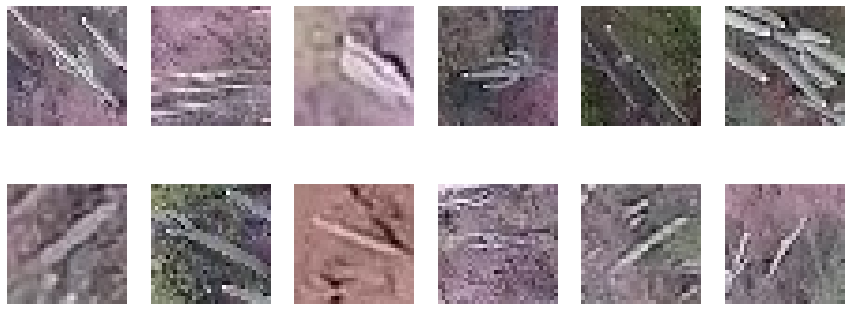

In [10]:
mpl.rc('font',size=7)
plt.figure(figsize=(15,6))
grid = gridspec.GridSpec(2,6)

last_has_cactus_img_name = labels[labels['has_cactus']==1]['id'][-12:]

for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = 'train/' + img_name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)
    plt.axis('off')

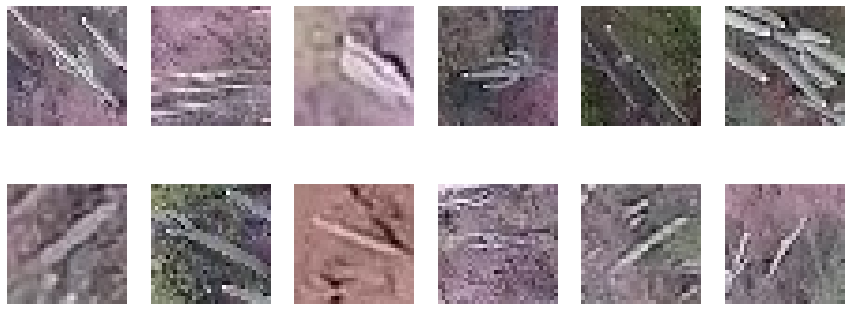

In [11]:
mpl.rc('font',size=7)
plt.figure(figsize=(15,6))
grid = gridspec.GridSpec(2,6)

last_hasnt_cactus_img_name = labels[labels['has_cactus']==0]['id'][-12:]

for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = 'train/' + img_name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)
    plt.axis('off')

In [12]:
image.shape

(32, 32, 3)

In [3]:
import torch
import random 
import numpy as np
import os

In [4]:
# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed) 
random.seed(seed)                          # 파이썬 난수 생성기 시드 고정
np.random.seed(seed)                       # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed)                    # 파이토치 난수 생성기 시드 고정(CPU 사용 시)
torch.cuda.manual_seed(seed)               # 파이토치 난수 생성기 시드 고정(GPU 사용 시)
torch.cuda.manual_seed_all(seed)           # 파이토치 난수 생성기 시드 고정(멀티 GPU 사용 시)
torch.backends.cudnn.deterministic = True # 확정적 연산 사용
torch.backends.cudnn.benchmark = False    # 벤치마크 기능 해제
torch.backends.cudnn.enable = False       # cudnn 사용 해제

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [9]:
# 다음처럼 한 줄로 표현 가능
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
device

device(type='cpu')

In [21]:
import pandas as np

In [22]:
data_path = 'data/'

labels = pd.read_csv(data_path + 'train.csv')

In [23]:
from sklearn.model_selection import train_test_split

# 훈련데이터, 검증 데이터 분리
train, valid = train_test_split(labels,
                               test_size = 0.1,
                               stratify=labels['has_cactus'],
                               random_state=50)

In [20]:
print(len(train)) # 훈련 데이터 개수
print(len(valid))  # 검증 데이터 개수
# 비율이 9:1인걸 알 수 있음

15750
1750


### 데이터셋 클래스 정의

In [21]:
import cv2
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스

In [22]:
class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir ='./', transform=None):
        super().__init__() # 상속받은 Dataset의 생성자 호출
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    
    # 인덱스(idx)에 해당하는 데이터 반환 매서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        img_path = self.img_dir + img_id
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx, 1]
        
        if self.transform is not None:
            image = self.transform(image) # 변환기가 있다면 이미지 변환
        return image, label

In [24]:
from torchvision import transforms # 이미지 변환을 위한 모듈

In [25]:
transform = transforms.ToTensor()

In [26]:
dataset_train = ImageDataset(df=train, img_dir='train/', transform=transform)
dataset_valid = ImageDataset(df=valid, img_dir='train/', transform=transform)

In [27]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

In [28]:
loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_vaild = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=True)

In [29]:
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수

In [30]:
class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__() 메서드 호출
        # 첫 번째 합성곱 계층
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32,
                              kernel_size=3, padding=2)
        # 두 번째 합성곱 계층
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
                              kernel_size=3, padding=2)
        # 최대 폴링 계층
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        # 평균 폴링 계층
        self.avg_pool = nn.AvgPool2d(kernel_size=2)
        # 전결합 계층
        self.fc = nn.Linear(in_features=64 * 4 * 4, out_features=2)
        
    # 순전파 출력 정의
    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = self.avg_pool(x)
        x = x.view(-1, 64 * 4 * 4) # 평탄화
        x = self.fc(x)
        
        return x

In [31]:
model = Model().to(device)

In [32]:
Model()

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

In [33]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

In [34]:
# 옵티마이저
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [35]:
import math

print(math.ceil(len(train)/ 32)) # 반복횟수 계산 방법 : 전체데이터/배치사이즈 = 반복횟수 , 1 epoch의 훈련을 완료하는데 필요한 훈련 이터레이션

# or 

# print(len(loader_train))

493


## 모델 훈련

In [36]:
epochs = 10 # 총 epoch
# 총 epoch만큼 반복
for epoch in range(epochs):
    epoch_loss = 0 # epoch별 손실값 초기화
    
    # '반복 횟수'만큼 반복
    for images, labels in loader_train:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() # 역전파 수행
        loss.backward()
        # 가중치 갱신
        optimizer.step()
        
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')
        

에폭 [1/10] - 손실값: 0.5233


KeyboardInterrupt: 